In [1]:
%pylab inline

import numpy as np
import pylab
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nengolib.signal import *
from nengolib.synapses import PureDelay, ss2sim

import nengolib
from scipy.special import factorial
from scipy.misc import pade

from numpy.linalg import matrix_power

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

class HandlerDashedLines(HandlerLineCollection):
    """Adapted from http://matplotlib.org/examples/pylab_examples/legend_demo5.html"""

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width / numlines, height, fontsize)
        leglines = []
        for i in range(numlines):
            legline = Line2D(xdata + i * width / numlines,
                             np.zeros_like(xdata.shape) - ydescent + height / 2)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

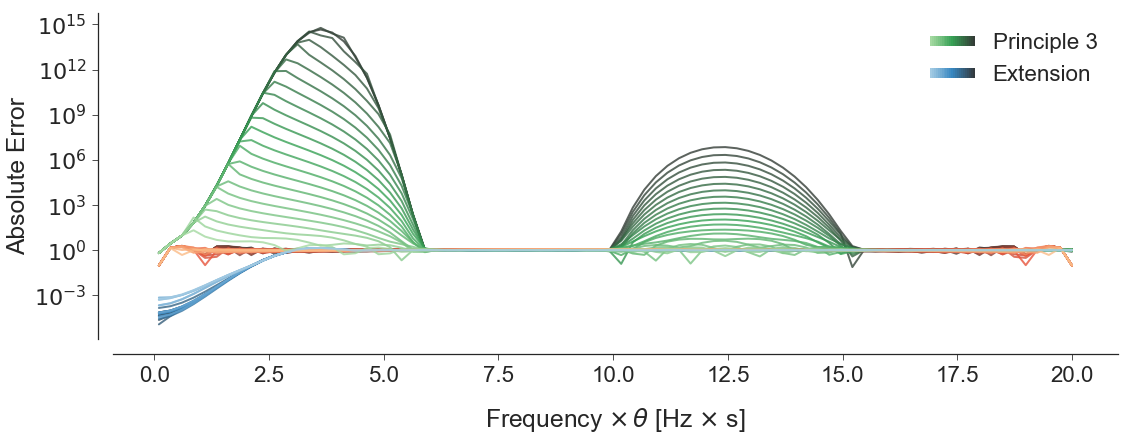

In [14]:
def lambert_delay(delay, sub_delay, tau, p, q):
    """Returns F = p/q s.t. F((tau*s+1)/e^(-sb)) = e^(-sa)."""
    a, b = delay, sub_delay
    r = a / b
    c = np.exp(a / tau)
    d = (b / tau) * np.exp(b / tau)
    i = np.arange(1, p + q + 1)
    taylor = np.append([1./r], (i+r)**(i-1) / factorial(i))
    tf = pade(taylor, q)
    nds = np.poly1d([-d, 0])  # -ds
    return nengolib.signal.LinearSystem(
        (c*r*tf[0](nds), tf[1](nds)), analog=True)

theta = 0.1
tau = 0.1 * theta
lmbda = tau
orders = range(6, 29)

freqs = np.linspace(0.1 / theta, 20 / theta, 80)
s = 2.j * np.pi * freqs

y = np.exp(-theta*s)
Hinvs = (tau*s + 1)*np.exp(lmbda*s)

cmap_lamb = sns.color_palette("Blues_d", len(orders))[::-1]
cmap_ignore = sns.color_palette("Greens_d", len(orders))[::-1]
cmap_deriv = sns.color_palette("OrRd_d", len(orders))[::-1]

def deriv_mapping(sys, H):
    c = H.den / H.num[0]
    k = len(H)
    A, B, C, D = sys.ss
    powA = [matrix_power(A, i) for i in range(k + 1)]
    AH = np.sum([c[i] * powA[i] for i in range(k + 1)], axis=0)
    BH = [np.dot(np.sum([c[i] * powA[i-j-1] for i in range(j+1, k+1)], axis=0), B)
          for j in range(k)]
    nums = []
    first_den = None
    for BHj in BH:
        num, den = LinearSystem((AH, BHj, C, D)).tf
        if first_den is None:
            first_den = den
        else:
            assert np.allclose(den, first_den)
        nums.append(num)
    #return BH, first_den
    return AH, BH, C, D


with sns.axes_style('ticks'):
    with sns.plotting_context('paper', font_scale=2.8):
        figure(figsize=(18, 6))
        for i, q in enumerate(orders):

            sys = PureDelay(theta, order=q)
            
            #j = np.arange(5)
            #c = (-lmbda)**j / factorial(j)
            #num, den = pade(c, len(j)-1  # (lmbda)**j / factorial(j)
            #Happrox = nengolib.signal.LinearSystem((num, den)) * nengolib.Lowpass(tau)
            #AH, BHs, CH, DH = deriv_mapping(sys, Happrox)
            #deriv_nums, deriv_den = deriv_mapping(sys, Happrox)
            #noderiv = ss2sim(sys, Happrox)
            mapped = ss2sim(sys, nengolib.Lowpass(tau))
            lambert = lambert_delay(theta, lmbda, tau, q-1, q)

            dt = 0.001
            z = np.exp(-s/dt)
            a = np.exp(-dt/tau)
            y_discrete = mapped((z - a) / (1 - a))
            y_check = ss2sim(sys, nengolib.Lowpass(tau), dt=dt)((z - a) / (1 - a))
            y_lamb = lambert(Hinvs)
            y_ignore = mapped(Hinvs)  # mapped(tau*s + 1)
            #y_noderiv = noderiv(Hinvs)
            #y_deriv = np.zeros_like(y_lamb)
            #for k, (sk, sinvk) in enumerate(zip(s, Hinvs)):
            #    BH = np.sum([sk**j * BHj for j, BHj in enumerate(BHs)], axis=0)
            #    y_deriv[k] = LinearSystem((AH, BH, CH, DH))(sinvk)
            #y_deriv = mapped(tau*s + 1)
                
            semilogy(freqs*theta, abs(np.exp(-theta*z) - y_check), lw=2, alpha=0.8,
                     zorder=len(orders)-i, c=cmap_deriv[i])
            semilogy(freqs*theta, abs(y - y_ignore), lw=2, alpha=0.8,
                     zorder=len(orders)-i, c=cmap_ignore[i])
            semilogy(freqs*theta, abs(y - y_lamb), lw=2, alpha=0.8,
                     zorder=len(orders)-i, c=cmap_lamb[i])
            
            #if q < 10:
            #    semilogy(freqs*theta, abs(y - y_deriv), lw=2, alpha=0.8,
            #             zorder=len(orders)-i, c=cmap_deriv[i])
            #plot(freqs*theta, np.exp(-s*theta).real, c='black')

        sns.despine(offset=15)

        lc_ignore = LineCollection(
            len(orders) * [[(0, 0)]], lw=10, colors=cmap_ignore)
        lc_lamb = LineCollection(
            len(orders) * [[(0, 0)]], lw=10, colors=cmap_lamb)
        legend([lc_ignore, lc_lamb], ['Principle 3', 'Extension'], handlelength=2,
                handler_map={LineCollection: HandlerDashedLines()})
        
        xlabel(r"Frequency $\times \, \theta$ [Hz $\times$ s]", labelpad=20)
        ylabel(r"Absolute Error")
        
        legend()
        show()
        
        # TODO: COMPARE TO EQUATION 25!!!

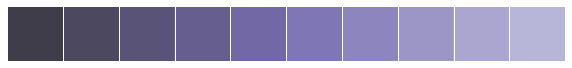

In [46]:
sns.choose_colorbrewer_palette('sequential')

In [80]:
j = np.arange(5)
c = (-lmbda)**j / factorial(j)
print pade(c, len(j)-1)

print (lmbda)**j / factorial(j)

(poly1d([ 1.]), poly1d([  4.16666667e-10,   1.66666667e-07,   5.00000000e-05,
         1.00000000e-02,   1.00000000e+00]))
[  1.00000000e+00   1.00000000e-02   5.00000000e-05   1.66666667e-07
   4.16666667e-10]
